In [877]:
import pandas as pd
import numpy as np
from lightgbm import LGBMRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import root_mean_squared_error
import seaborn as sns

In [878]:
submission = pd.read_csv("sample_submission.csv")
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")
original = pd.read_csv("original.csv")

In [879]:
target = "Calories"

In [880]:
train.head()

,id,Sex,Age,Height,Weight,Duration,Heart_Rate,Body_Temp,Calories
0,0,male,36,189.0,82.0,26.0,101.0,41.0,150.0
1,1,female,64,163.0,60.0,8.0,85.0,39.7,34.0
2,2,female,51,161.0,64.0,7.0,84.0,39.8,29.0
3,3,male,20,192.0,90.0,25.0,105.0,40.7,140.0
4,4,female,38,166.0,61.0,25.0,102.0,40.6,146.0


In [881]:
train.drop('id', axis=1, inplace=True)
test.drop('id', axis=1, inplace=True)

Rescale target to log scale

In [882]:
train[target] = np.log1p(train[target])
original[target] = np.log1p(original[target])

In [883]:
train

,Sex,Age,Height,Weight,Duration,Heart_Rate,Body_Temp,Calories
0,male,36,189.0,82.0,26.0,101.0,41.0,5.017280
1,female,64,163.0,60.0,8.0,85.0,39.7,3.555348
2,female,51,161.0,64.0,7.0,84.0,39.8,3.401197
3,male,20,192.0,90.0,25.0,105.0,40.7,4.948760
4,female,38,166.0,61.0,25.0,102.0,40.6,4.990433
...,...,...,...,...,...,...,...,...
749995,male,28,193.0,97.0,30.0,114.0,40.9,5.442418
749996,female,64,165.0,63.0,18.0,92.0,40.5,4.574711
749997,male,60,162.0,67.0,29.0,113.0,40.9,5.402677
749998,male,45,182.0,91.0,17.0,102.0,40.3,4.700480


In [884]:
train["Sex"] = train["Sex"]=="male"
test["Sex"] = test["Sex"]=="male"
train

,Sex,Age,Height,Weight,Duration,Heart_Rate,Body_Temp,Calories
0,True,36,189.0,82.0,26.0,101.0,41.0,5.017280
1,False,64,163.0,60.0,8.0,85.0,39.7,3.555348
2,False,51,161.0,64.0,7.0,84.0,39.8,3.401197
3,True,20,192.0,90.0,25.0,105.0,40.7,4.948760
4,False,38,166.0,61.0,25.0,102.0,40.6,4.990433
...,...,...,...,...,...,...,...,...
749995,True,28,193.0,97.0,30.0,114.0,40.9,5.442418
749996,False,64,165.0,63.0,18.0,92.0,40.5,4.574711
749997,True,60,162.0,67.0,29.0,113.0,40.9,5.402677
749998,True,45,182.0,91.0,17.0,102.0,40.3,4.700480


In [885]:
trainX = train.drop(target, axis=1)
trainY = train[target]

In [886]:
X_train, X_val, Y_train, Y_val = train_test_split(trainX, trainY, train_size=0.75)

In [887]:
lgbm_base = LGBMRegressor(objective='regression',n_estimators=300, learning_rate=0.1, max_depth=10, n_jobs=-1)
lgbm_base.fit(X_train, Y_train)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003608 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 360
[LightGBM] [Info] Number of data points in the train set: 562500, number of used features: 7
[LightGBM] [Info] Start training from score 4.142054


LGBMRegressor(max_depth=10, n_estimators=300, n_jobs=-1, objective='regression')

In [888]:
Y_pred = lgbm_base.predict(X_val)

In [889]:
residual_df = pd.DataFrame()
residual_df["actual"] = np.expm1(Y_val)
residual_df["predicted"] = np.expm1(Y_pred) # transform log scale back to original calories scale
residual_df

,actual,predicted
483968,104.0,100.790160
318640,125.0,127.234147
740244,231.0,227.102189
626618,198.0,203.457088
438631,118.0,114.091856
...,...,...
738046,21.0,20.413987
10932,65.0,62.496789
282998,21.0,19.504889
578360,25.0,23.884522


<Axes: xlabel='predicted', ylabel='actual'>

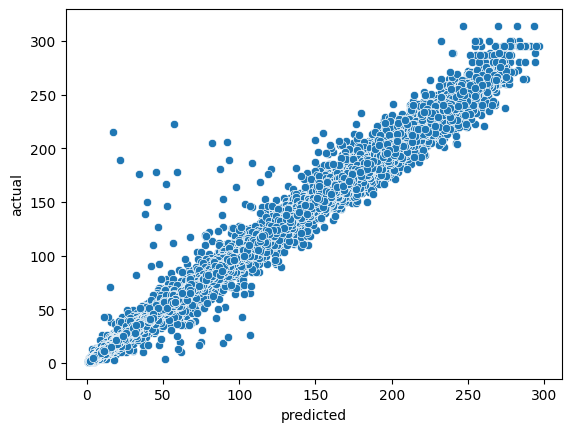

In [890]:
sns.scatterplot(residual_df, x="predicted", y="actual")

In [891]:
root_mean_squared_error(Y_val, Y_pred) # root mean squared log error as we're using log scale for target

np.float64(0.0615063717857031)

In [892]:
lgbm_base.fit(trainX, trainY) # train on rest of the data

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003439 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 357
[LightGBM] [Info] Number of data points in the train set: 750000, number of used features: 7
[LightGBM] [Info] Start training from score 4.141144


LGBMRegressor(max_depth=10, n_estimators=300, n_jobs=-1, objective='regression')

In [893]:
test_pred = lgbm_base.predict(test)

In [894]:
submission[target] = np.expm1(test_pred)
submission

,id,Calories
0,750000,27.081477
1,750001,108.436956
2,750002,86.436114
3,750003,124.601856
4,750004,75.356008
...,...,...
249995,999995,26.268046
249996,999996,9.079385
249997,999997,72.855703
249998,999998,168.441655


In [895]:
submission.to_csv("submission.csv", index=False)